In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The dataset shareable link

#new stylo data
#link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'
link = 'https://drive.google.com/open?id=15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l'

fluff, id = link.split('=')
print(id)
filename = 'stylo-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

#news stylo dataset
news_link = 'https://drive.google.com/open?id=1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c'
fluff, id = news_link.split('=')
print(id)
news_filename = 'news-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(news_filename)

# varela stylo dataset
varela_link = 'https://drive.google.com/open?id=1_RZDCOie5xAD2IMcrLFFMNZjkzHtZQEl'
fluff, id = varela_link.split('=')
print(id)
varela_filename = 'varela-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(varela_filename)

15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l
1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c
1_RZDCOie5xAD2IMcrLFFMNZjkzHtZQEl


In [3]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold, SelectPercentile, SelectFwe, RFECV,  chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer

!pip install -U keras
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import InputLayer, Embedding, Conv1D, MaxPool1D, Dense, Flatten, Dropout, GRU, LSTM, Input
from tensorflow.python.keras import Sequential, Model
from keras.initializers import Constant

from pprint import pprint

from imblearn.over_sampling import SMOTE

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# read dataset
df = pd.read_csv(filename)
df_news = pd.read_csv(news_filename)
df_varela = pd.read_csv(varela_filename)

# Remove subject column
df_varela.pop('Subject')

# Remove single class entries (We need at least 3 samples of an author)#
df = df.groupby('Author').filter(lambda x: len(x) > 3)


In [0]:
#Let's drop all the features that are not in our 'best' list

best_features = ['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas', 'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos', 'FrequenciaDeParagrafos',
'FrequenciaDeHapaxLegomenaLocal', 'Ponto', 'Virgulas','Exclamacoes', 'DoisPontos', 'FreqCitacoes', 'FreqAdv', 
'FreqSubs','FreqPrep','FreqVerbosPtcp','FreqPronomes','PronomesPorPreposicao','FreqTermosNaoTageados','FreqPalavrasDeConteudo',
'FreqECoisa','FreqEObra','FreqEOutro','FreqEPessoa','FreqETempo','GuiraudR','HerdanV','MedidaK','DugastU','FreqPalavrasComunsTam4',
'FreqPalavrasErradas','FrequenciaStopWords','BRFleshIndex']

df_news = df_news[best_features]

In [0]:
#Separate data from labels

y = df.pop('Author')
y_news = df_news.pop('Author')
y_varela = df_varela.pop('Author')

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(y_news)
encoded_y_news = le.transform(y_news)

le = LabelEncoder()
le.fit(y_varela)
encoded_Y_varela = le.transform(y_varela)

In [0]:
# Feature selection

# Baseline (Variance threshold):
threshold=(.01)
selector = VarianceThreshold(threshold)
selector.fit(df)

#df.columns[selector.get_support(indices=True)] # 20 features, data has very low variance (features are mostly very close)

selector.fit(df_news)

df_news.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'MediaSilabasPorPalavra', 'Ponto', 'Virgulas', 'Exclamacoes',
       'DoisPontos', 'PronomesPorPreposicao', 'GuiraudR', 'HerdanV', 'MedidaK',
       'DugastU', 'BRFleshIndex'],
      dtype='object')

In [0]:
# 50% better based on percentile using chi2
selector = SelectPercentile(chi2, percentile=40)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'Ponto', 'Virgulas', 'Exclamacoes', 'DoisPontos',
       'PronomesPorPreposicao', 'FreqEAcontecimento', 'FreqEOrganizacao',
       'FreqEObra', 'FreqEOutro', 'FreqETempo', 'GuiraudR', 'HerdanV',
       'DugastU', 'HonoresH', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [0]:
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df_news, y_news)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'Ponto', 'Virgulas', 'Exclamacoes', 'DoisPontos', 'FreqCitacoes',
       'FreqAdv', 'FreqVerbosPtcp', 'FreqPronomes', 'PronomesPorPreposicao',
       'FreqTermosNaoTageados', 'FreqECoisa', 'FreqEObra', 'FreqEOutro',
       'FreqEPessoa', 'FreqETempo', 'GuiraudR', 'HerdanV', 'DugastU',
       'FreqPalavrasErradas', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [0]:
selector.get_support(indices=True)

array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 15, 20, 22, 23, 24, 31,
       34, 35, 36, 37, 39, 41, 43, 46, 47, 52])

In [0]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  1640.030726
5               StdevTamParagrafos  1190.145679
4           TamanhoMedioParagrafos  1083.505879
3                   StdevSentencas    83.212074
0                DiversidadeLexica    68.963605
2            TamanhoMedioSentencas    42.317390
43                         DugastU    40.001632
10                        Virgulas    12.506046
9                            Ponto     8.796392
12                      DoisPontos     8.654201
39                        GuiraudR     7.570860
11                     Exclamacoes     5.398750
52                    BRFleshIndex     2.558055
23           PronomesPorPreposicao     2.380678
47  FrequenciaDeHapaxLegomenaLocal     1.056917
1          TamanhoMedioDasPalavras     1.034314
45                        HonoresH     0.898729
30              FreqEAcontecimento     0.542428
37                      FreqETempo     0.538987
35                      FreqEOutro     0

In [0]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  2688.503948
5               StdevTamParagrafos  1707.831428
4           TamanhoMedioParagrafos  1103.327501
2            TamanhoMedioSentencas   862.748654
11                     Exclamacoes    59.697231
3                   StdevSentencas    59.007145
0                DiversidadeLexica    37.698913
43                         DugastU    33.392413
39                        GuiraudR    22.573796
10                        Virgulas    21.582665
9                            Ponto    16.308883
12                      DoisPontos    12.164414
23           PronomesPorPreposicao     6.568906
52                    BRFleshIndex     4.978543
1          TamanhoMedioDasPalavras     1.791226
24           FreqTermosNaoTageados     0.810441
35                      FreqEOutro     0.551372
34                       FreqEObra     0.526174
22                    FreqPronomes     0.487441
47  FrequenciaDeHapaxLegomenaLocal     0

In [0]:
# K-Best (f_classif)
best_k_features = SelectKBest(f_classif, k=30).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df_news.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(30,'Score'))

                           Feature      Score
11                     Exclamacoes  19.089614
39                        GuiraudR  13.163038
22                    FreqPronomes  12.735249
25          FreqPalavrasDeConteudo  12.442170
24           FreqTermosNaoTageados  12.376033
42                         MedidaK  12.154679
23           PronomesPorPreposicao  10.844617
1          TamanhoMedioDasPalavras  10.182572
15                         FreqAdv   9.488145
51             FrequenciaStopWords   9.291832
41                         HerdanV   9.033462
18                        FreqPrep   8.457826
17                        FreqSubs   8.408751
6           FrequenciaDeParagrafos   8.297498
20                  FreqVerbosPtcp   6.958381
4           TamanhoMedioParagrafos   6.232975
43                         DugastU   6.214138
46             FreqPalavrasErradas   6.084080
0                DiversidadeLexica   5.951392
44                           MaasA   5.548263
5               StdevTamParagrafos

Optimal number of features news-dataset: 40
Optimal number of features students-dataset: 49


<Figure size 432x288 with 0 Axes>

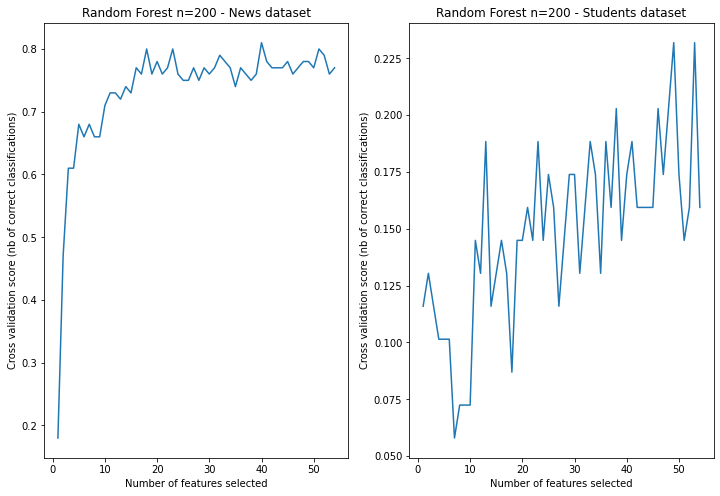

<Figure size 432x288 with 0 Axes>

In [0]:
# Create the RFE object and compute a cross-validated score.
rfc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features news-dataset: %d" % rfecv.n_features_)

rfecv2 = RFECV(estimator=rfc, step=1, cv=3,
              scoring='accuracy')
rfecv2.fit(df, y)

print("Optimal number of features students-dataset: %d" % rfecv2.n_features_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Random Forest n=200 - News dataset')

ax2.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
ax2.set_xlabel("Number of features selected")
ax2.set_ylabel("Cross validation score (nb of correct classifications)")
ax2.set_title('Random Forest n=200 - Students dataset')

plt.figure()

In [0]:
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

X_student, X_student_test, Y_student, Y_student_test = train_test_split(df.values, encoded_Y, random_state=11, test_size=0.2)
X_student_test, X_student_val, Y_student_test, y_student_val = train_test_split(X_student_test, Y_student_test, random_state=11, test_size=0.5)

X_varela, X_varela_test, Y_varela, y_varela_test = train_test_split(df_varela, encoded_Y_varela, random_state=7, test_size=0.3)
X_varela_test, X_varela_val, y_varela_test, y_varela_val = train_test_split(X_varela_test, y_varela_test, random_state=7, test_size=0.5)

In [21]:
X_varela.head()

,DiversidadeLexica,TamanhoMedioDasPalavras,TamanhoMedioSentencas,StdevSentencas,TamanhoMedioParagrafos,StdevTamParagrafos,FrequenciaDeParagrafos,FrequenciaPalavrasDuplicadas,MediaSilabasPorPalavra,Ponto,Virgulas,Exclamacoes,DoisPontos,FreqCitacoes,FreqAdjetivos,FreqAdv,FreqArt,FreqSubs,FreqPrep,FreqVerb,FreqVerbosPtcp,FreqConj,FreqPronomes,PronomesPorPreposicao,FreqTermosNaoTageados,FreqPalavrasDeConteudo,FreqPalavrasFuncionais,FrequenciaFrasesNominais,FreqTotalEntidadesNomeadas,FreqEAbstracao,FreqEAcontecimento,FreqECoisa,FreqELocal,FreqEOrganizacao,FreqEObra,FreqEOutro,FreqEPessoa,FreqETempo,FreqEValor,GuiraudR,HerdanC,HerdanV,MedidaK,DugastU,MaasA,HonoresH,FreqPalavrasErradas,FrequenciaDeHapaxLegomenaLocal,FreqPalavrasComunsTam2,FreqPalavrasComunsTam3,FreqPalavrasComunsTam4,FrequenciaStopWords,BRFleshIndex,FreqOperadoresLogicos
1283,77.631579,5.389831,23.000000,7.071068,69.0,0.0,0.013158,0.026316,2.065789,3.947368,2.631579,0.000000,0.000000,0.026316,0.052632,0.039474,0.105263,0.171053,0.157895,0.013158,0.092105,0.039474,0.000000,0.000000,0.197368,0.394737,0.302632,0.000000,0.092105,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.285714,0.000000,0.285714,0.285714,6.767764,0.941535,59.0,2.225427,106.866298,0.096734,0.864407,0.105263,0.671053,0.000000,0.000000,0.000000,0.394737,423.520658,0.039474
1888,53.703704,6.800000,26.333333,18.168349,395.0,0.0,0.002315,0.046296,2.243056,3.472222,4.861111,0.000000,0.000000,0.000000,0.064815,0.048611,0.081019,0.196759,0.115741,0.020833,0.134259,0.067130,0.062500,0.540000,0.069444,0.495370,0.263889,0.013889,0.111111,0.020833,0.104167,0.041667,0.104167,0.104167,0.041667,0.125000,0.062500,0.291667,0.104167,11.162105,0.897554,232.0,2.510466,85.458244,0.108174,0.801724,0.050926,0.430556,0.006944,0.011574,0.013889,0.416667,438.545810,0.074074
1454,61.320755,5.776923,23.250000,14.838716,186.0,0.0,0.004717,0.056604,1.995283,3.773585,6.132075,0.000000,0.471698,0.009434,0.042453,0.033019,0.099057,0.169811,0.117925,0.009434,0.108491,0.033019,0.028302,0.240000,0.141509,0.457547,0.250000,0.018868,0.113208,0.208333,0.041667,0.083333,0.125000,0.125000,0.083333,0.125000,0.000000,0.125000,0.083333,8.928437,0.908701,130.0,2.380399,84.643939,0.108693,0.800000,0.070755,0.490566,0.004717,0.009434,0.009434,0.344340,417.597642,0.033019
1523,44.954955,6.494990,17.627451,11.263268,899.0,0.0,0.000901,0.053153,1.995495,3.873874,8.738739,0.270270,0.810811,0.000000,0.059459,0.045946,0.090090,0.137838,0.079279,0.009910,0.091892,0.045946,0.065766,0.829545,0.127027,0.381982,0.215315,0.010811,0.091892,0.058824,0.137255,0.058824,0.088235,0.098039,0.098039,0.049020,0.009804,0.245098,0.156863,14.977491,0.885982,499.0,2.684614,88.725646,0.106164,0.779559,0.084685,0.350450,0.014414,0.018018,0.018018,0.352252,417.608198,0.037838
1696,41.788478,6.374486,24.631579,17.504016,936.0,0.0,0.000860,0.081685,1.964746,2.837489,9.114359,0.171969,0.687876,0.049871,0.030095,0.042132,0.084265,0.161651,0.076526,0.020636,0.105761,0.045572,0.061909,0.808989,0.124678,0.437661,0.206363,0.012898,0.085985,0.070000,0.080000,0.030000,0.170000,0.060000,0.030000,0.090000,0.080000,0.310000,0.080000,14.251035,0.876388,486.0,2.665571,82.383655,0.110174,0.707819,0.049011,0.295787,0.017197,0.017197,0.017197,0.351677,415.014140,0.036113


In [17]:
model = ExtraTreesClassifier(n_estimators=350, random_state=11)

model.fit(X, Y)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("News Test score: %.2f%%" % (score * 100))


model = ExtraTreesClassifier(n_estimators=350, random_state=11)
model.fit(X_student, Y_student)

y_pred = model.predict(X_student_test)

score = accuracy_score(Y_student_test, y_pred)
print("Students Test score: %.2f%%" % (score * 100))


model = ExtraTreesClassifier(n_estimators=800, random_state=11)
model.fit(X_varela, Y_varela)

y_pred = model.predict(X_varela_test)

score = accuracy_score(y_varela_test, y_pred)
print("Varela Test score: %.2f%%" % (score * 100))

News Test score: 73.33%
Students Test score: 14.29%
Varela Test score: 56.67%


In [0]:
# Hyper-tuning our classifiers

# TODO: Extract this into reusable function!

n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                
etc = ExtraTreesClassifier(random_state=11)

# search across 100 different combinations, and use all available cores
news_best_estimator_search = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=0, random_state=11, n_jobs=-1)

news_best_estimator_search.fit(X, Y)

students_best_estimator_search = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=11, n_jobs=-1)

students_best_estimator_search.fit(X_student, Y_student)


pprint(news_best_estimator_search.best_params_)
pprint(students_best_estimator_search.best_params_)

In [26]:
Y_varela.shape

(2100,)

In [27]:
varela_best_estimator_search = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=0, random_state=11, n_jobs=-1)

varela_best_estimator_search.fit(X_varela, Y_varela)
pprint(varela_best_estimator_search.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 866}


In [29]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

# Let's now check the accuracy on both validation datasets (not seen by the classifier yet)
new_X = np.concatenate((X, X_test))
new_Y = np.concatenate((Y, y_test))

news_best_estimator_search.best_estimator_.fit(new_X, new_Y)
predictions = news_best_estimator_search.best_estimator_.predict(X_val)
base_score = accuracy_score(predictions, y_val)
print('Average accuracy news:' + str(base_score))
#pprint(classification_report(y_val, predictions))

new_X_student = np.concatenate((X_student, X_student_test))
new_Y_student = np.concatenate((Y_student, Y_student_test))

students_best_estimator_search.best_estimator_.fit(new_X_student, new_Y_student)
predictions = students_best_estimator_search.best_estimator_.predict(X_student_val)
base_score = accuracy_score(predictions, y_student_val)
print('Average accuracy students:' + str(base_score))

new_X_varela = np.concatenate((X_varela, X_varela_test))
new_Y_varela = np.concatenate((Y_varela, y_varela_test))

varela_best_estimator_search.best_estimator_.fit(new_X_varela, new_Y_varela)
predictions = varela_best_estimator_search.best_estimator_.predict(X_varela_val)
varela_score = accuracy_score(predictions, y_varela_val)
print('Accuracy varela:' + str(varela_score))


Average accuracy news:0.8
Average accuracy students:0.14285714285714285
Accuracy varela:0.5644444444444444


Optimal number of features for best estimator news-dataset: 54


<Figure size 432x288 with 0 Axes>

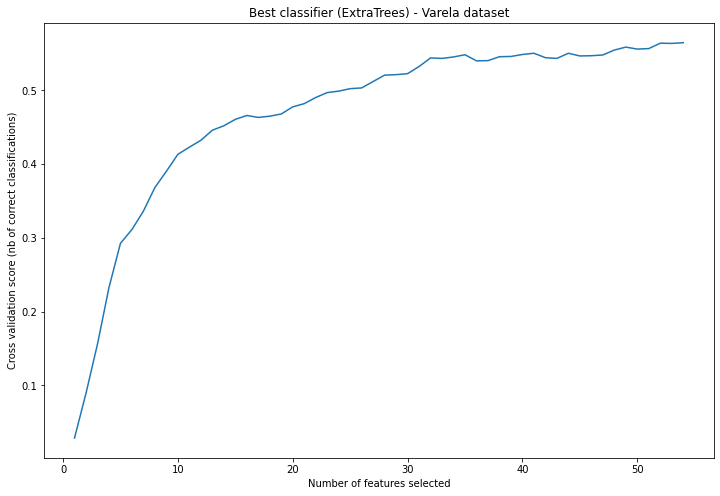

<Figure size 432x288 with 0 Axes>

In [11]:
rfecv_varela = RFECV(estimator=ExtraTreesClassifier(n_estimators=866), step=1, cv=5,scoring='accuracy')
rfecv_varela.fit(df_varela, encoded_Y_varela)

varela_best_features_num = rfecv_varela.n_features_

print("Optimal number of features for best estimator news-dataset: %d" % varela_best_features_num)

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv_varela.grid_scores_) + 1), rfecv_varela.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Best classifier (ExtraTrees) - Varela dataset')


plt.figure()

In [0]:

# print the metrics if needed

# precision_recall_fscore_support(y_test, predictions, average='macro')

# pprint(classification_report(y_student_val, predictions))

 #print ("AUC&ROC",roc_auc_score(y_test, predictions, multi_class='ovr'))

Optimal number of features for best estimator news-dataset: 22
Optimal number of features for best estimator students-dataset: 26


<Figure size 432x288 with 0 Axes>

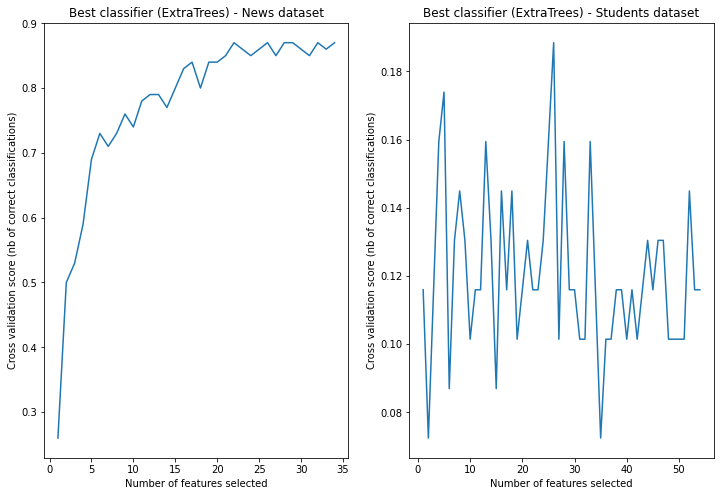

<Figure size 432x288 with 0 Axes>

In [0]:
rfecv = RFECV(estimator=news_best_estimator_search.best_estimator_, step=1, cv=5,scoring='accuracy')
rfecv.fit(df_news, encoded_y_news)

news_best_features_num = rfecv.n_features_

print("Optimal number of features for best estimator news-dataset: %d" % news_best_features_num)

rfecv2 = RFECV(estimator=students_best_estimator_search.best_estimator_, step=1, cv=3,
              scoring='accuracy')
rfecv2.fit(df, encoded_Y)

students_best_features_num = rfecv2.n_features_

print("Optimal number of features for best estimator students-dataset: %d" % students_best_features_num)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Best classifier (ExtraTrees) - News dataset')

ax2.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
ax2.set_xlabel("Number of features selected")
ax2.set_ylabel("Cross validation score (nb of correct classifications)")
ax2.set_title('Best classifier (ExtraTrees) - Students dataset')

plt.figure()

In [0]:
# Dummy function to make label names shorter and help visualize our graph

def make_label(text):
  if len(text) > 6:
    sub_text = text[:6]
    capitals = ''.join([c for c in text if c.isupper()])
    numbers = ''.join([c for c in text if c.isdigit()])
    text = capitals[0] + sub_text[1:] + capitals[1:] + numbers 
  return text

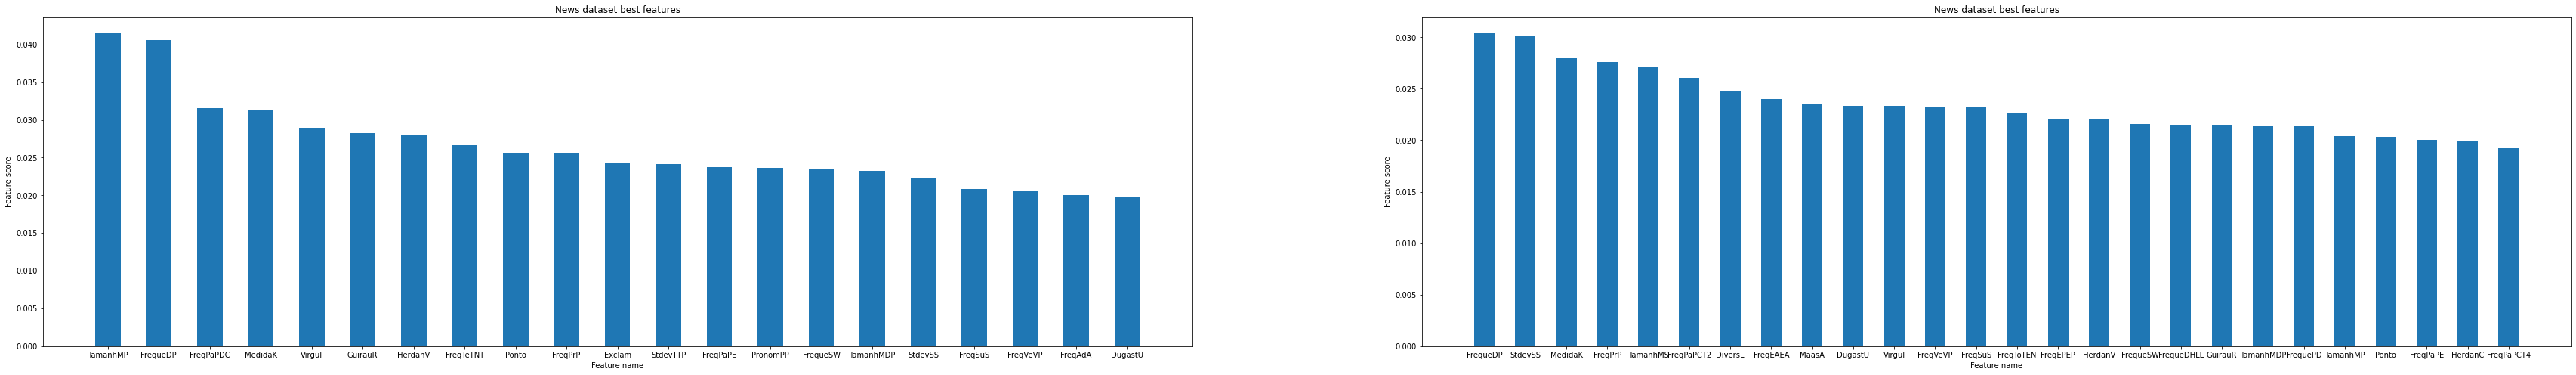

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(60, 8)

news_features = news_feat_importances.nlargest(news_best_features_num)
height_news = [i for i in news_features]
 
ax1.set_xlabel("Feature name")
ax1.set_ylabel("Feature score")
ax1.set_title('News dataset best features')
smaller_news_labels = [make_label(ft) for ft in news_features.index]
ax1.bar(smaller_news_labels, height_news, 0.5)

std_features = student_feat_importances.nlargest(students_best_features_num)
height_std = [i for i in std_features]
ax2.set_xlabel("Feature name")
ax2.set_ylabel("Feature score")
ax2.set_title('News dataset best features')
smaller_std_labels = [make_label(ft) for ft in std_features.index]
ax2.bar(smaller_std_labels, height_std, 0.5)


plt.show()

In [0]:
print(news_features.index)
print(std_features.index)

Index(['TamanhoMedioParagrafos', 'FrequenciaDeParagrafos',
       'FreqPalavrasDeConteudo', 'MedidaK', 'Virgulas', 'GuiraudR', 'HerdanV',
       'FreqTermosNaoTageados', 'Ponto', 'FreqPronomes', 'Exclamacoes',
       'StdevTamParagrafos', 'FreqPalavrasErradas', 'PronomesPorPreposicao',
       'FrequenciaStopWords', 'TamanhoMedioDasPalavras', 'StdevSentencas',
       'FreqSubs', 'FreqVerbosPtcp', 'FreqAdv', 'DugastU', 'FreqPrep'],
      dtype='object')
Index(['FrequenciaDeParagrafos', 'StdevSentencas', 'MedidaK', 'FreqPronomes',
       'TamanhoMedioSentencas', 'FreqPalavrasComunsTam2', 'DiversidadeLexica',
       'FreqEAbstracao', 'MaasA', 'DugastU', 'Virgulas', 'FreqVerbosPtcp',
       'FreqSubs', 'FreqTotalEntidadesNomeadas', 'FreqEPessoa', 'HerdanV',
       'FrequenciaStopWords', 'FrequenciaDeHapaxLegomenaLocal', 'GuiraudR',
       'TamanhoMedioDasPalavras', 'FrequenciaPalavrasDuplicadas',
       'TamanhoMedioParagrafos', 'Ponto', 'FreqPalavrasErradas', 'HerdanC',
       'FreqPalavra

In [0]:
# TODO: Finish the pipeline with feature selection + normalization + classification + hypertuning + metrics report
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)

treeclf = ExtraTreesClassifier(n_estimators=400, random_state=11)

clf = Pipeline([
  ('feature_selection', RFECV(estimator=treeclf, step=1, cv=5, scoring='accuracy')),
  ('classification', ExtraTreesClassifier(random_state=11))
])
clf.fit(X, Y)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("Test score: %.2f%%" % (score * 100))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Test score: 66.67%


In [0]:
X, X_test, Y, y_test = train_test_split(df_news, encoded_y_news, random_state=7, test_size=0.3)
#X, X_test, Y, y_test = train_test_split(df.values, encoded_Y, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

test_scores = []
val_scores = []
for i in range(0,10):

  model = ExtraTreesClassifier(n_estimators=400, random_state=11)
  model.fit(X, Y)

  y_pred = model.predict(X_test)

  score = accuracy_score(y_test, y_pred)
  #print("Test score: %.2f%%" % (score * 100))
  test_scores.append(score * 100)

  y_pred = model.predict(X_val)
  score = accuracy_score(y_val, y_pred)
  #print("Validation score: %.2f%%" % (score * 100))
  val_scores.append(score * 100)


print("Test score: %.2f%%" % (np.mean(test_scores)))
print("Validation score: %.2f%%" % (np.mean(val_scores)))


Test score: 73.33%
Validation score: 66.67%


In [0]:
# Let's manually imballance the dataset to make it look more like students dataset
from random import randrange

df_test = pd.read_csv(news_filename)

safe_ids = [i for i in set([randrange(5) * i for i in range(1,40)]) if i < 100]
df_test = df_test.drop(safe_ids)
df_test.shape

# Let's remove more samples for the first 3 classes
def remove_by_author(author, df):
  for idx in df.loc[df['Author'] == author].index:
    #lets give 0.5 chance to drop each feature
    chance = randrange(2)
    if chance == 1:
      df = df.drop(idx)
  return df

# Lets also give a random chance of removing these authors texts
df_test = remove_by_author("'SP'", df_test)
df_test = remove_by_author("'VSAL'", df_test)
df_test = remove_by_author("'MC'", df_test)
df_test = remove_by_author("'KM'", df_test)

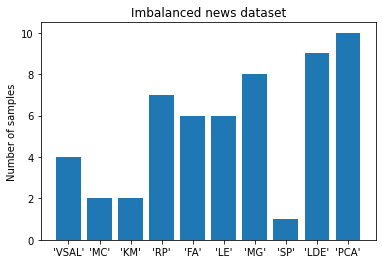

In [0]:
authors = {}
for author in set(df_test['Author']):
  authors[author] = len(df_test.loc[df_test['Author'] == author])

height = authors.values()
bars = authors.keys()
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
 
plt.title('Imbalanced news dataset')
plt.ylabel('Number of samples')
plt.show()

In [0]:
#Separate data from labels
y_news_imbalanced = df_test.pop('Author')

le = LabelEncoder()
le.fit(y_news_imbalanced)
encoded_Y_news_imbalanced = le.transform(y_news_imbalanced)

In [0]:
# Now let's use our best classifier from balanced dataset do see accuracy after imbalance

X, X_test, Y, y_test = train_test_split(df_test.values, encoded_Y_news_imbalanced, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

# Hyper-tuning our classifier
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                

rf_random_imbalanced = RandomizedSearchCV(estimator = ExtraTreesClassifier(random_state=11), 
                                          param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random_imbalanced.fit(X, Y)

pprint(rf_random_imbalanced.best_params_)

best_imbl_model = rf_random_imbalanced.best_estimator_
imbl_predictions = best_imbl_model.predict(X_test)
best_score = accuracy_score(imbl_predictions, y_test)
print(best_score)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1389}
0.875


In [0]:
# Let's now check the accuracy of our new imbalanced model
new_X = np.concatenate((X, X_test))
new_Y = np.concatenate((Y, y_test))

best_imbl_model.fit(new_X, new_Y)
imbl_predictions = best_imbl_model.predict(X_val)
best_score = accuracy_score(imbl_predictions, y_val)

# It looks like class imbalance was not a problem after all
print(best_score)

0.7777777777777778


In [0]:
# Checking the results of a simple neural network..
# Looks like TensorFlow 2.x is causing neural networks not to work correctly - In my machine it works :p
X, X_test, Y, y_test = train_test_split(df_news, encoded_y_news, random_state=11, test_size=0.3)
model = Sequential()
model.add(Dense(12, input_shape=[54], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, Y, epochs=250, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))